In [ ]:
import numpy as np
import shap
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Define KAN symoblic function
def compute_YCHF(inputs):
    X1, X2, X3, X4, X5, X6 = inputs
    term1 = 0.6936 * np.cos(1.5813 * X1 - 4.589)
    term2 = -0.0589 * np.tan(2.7642 * X3 - 4.5831)
    term3 = -0.3475 * np.tan(2.212 * X4 - 1.4029)
    term4 = 0.6529 * np.tan(0.6 * X5 + 9.9968)
    term5 = 0.9714 * np.arctanh(1.0 * X2 - 0.992)
    term6 = 1.3965
    term7 = 0.4367 * np.exp(-6.1413 * (0.2107 - X6)**2)
    inner_tanh = term1 + term2 + term3 + term4 + term5 + term6 + term7
    YCHF = 0.6975 - 0.6996 * np.tanh(inner_tanh)
    return YCHF

#mir: I am using test data to generate SHAP values
#whatever data you have used to derive FNN SHAP values, you should use the same for KAN
test_path = 'chf_valid.csv'
test_data = pd.read_csv(test_path)
#Inputs: D, L, P, G, T, Xe (pay attention to the order)
feature_names = test_data.columns
x_test = test_data.iloc[:, [0, 1, 2, 3, 4, 5]].values  # Input columns (1-6)
y_test = test_data.iloc[:, [6]].values  # Input columns (1-6)

#do not forget scaling
xscaler=MinMaxScaler()
x_test_scaled=xscaler.fit_transform(x_test)

# Define a wrapper function for SHAP
def model(inputs):
    # Apply the custom function to multiple samples
    return np.array([compute_YCHF(x) for x in inputs])

#get use the scaled array for SHAP
X_samples = x_test_scaled.copy()

# Initialize KernelExplainer
#mir: try ExactExplainer if it is faster and easier to use
explainer = shap.KernelExplainer(model, X_samples[0:300])  # Use a subset of data for reference values

# Compute SHAP values for a subset of samples
shap_values = explainer.shap_values(X_samples[0:])  # Analyze all samples

#make a bar plot like FNN, use consistent naming, color, styling, and so on ....

/Users/clover/mambaforge3/envs/myshapenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 5363/5363 [10:37<00:00,  8.41it/s]


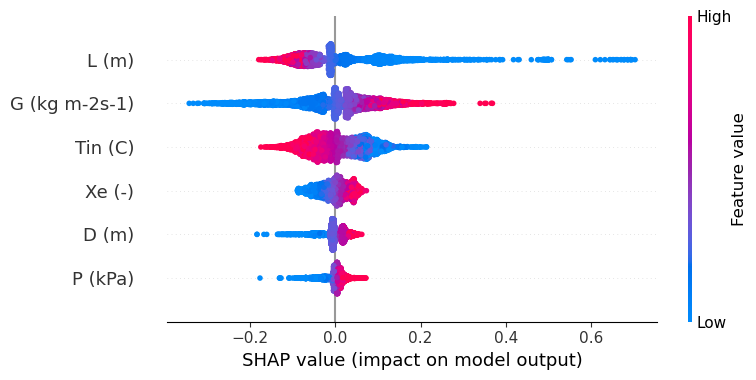

In [2]:
# Plot SHAP summary
shap.summary_plot(shap_values, X_samples[0:], feature_names=feature_names)

In [5]:
shap_values.mean(axis=0)

array([ 0.00021712,  0.00870656, -0.0002792 ,  0.00183818,  0.00485822,
       -0.00192147])

In [7]:
# post process shap results
output_names = [r"$CHF$ $[\frac{kW}{m^2}]$"]
feature_names = [r"$D$ $[m]$", r"$L$ $[m]$", r"$P$ $[kPa]$", r"$G$ $[\frac{kg}{m^2s}]$", r"$T_{In}$ $[^{\circ}C]$", r"$X_e$ $[-]$"]
shap_mean = pd.DataFrame(
    np.abs(shap_values).mean(axis=0),
    columns=output_names,
    index=feature_names,
    )
print(shap_mean)

                         $CHF$ $[\frac{kW}{m^2}]$
$D$ $[m]$                                0.020173
$L$ $[m]$                                0.081283
$P$ $[kPa]$                              0.015639
$G$ $[\frac{kg}{m^2s}]$                  0.076858
$T_{In}$ $[^{\circ}C]$                   0.053041
$X_e$ $[-]$                              0.028019


$L$ $[m]$                  0.081283
$G$ $[\frac{kg}{m^2s}]$    0.076858
$T_{In}$ $[^{\circ}C]$     0.053041
$X_e$ $[-]$                0.028019
$D$ $[m]$                  0.020173
$P$ $[kPa]$                0.015639
Name: $CHF$ $[\frac{kW}{m^2}]$, dtype: float64


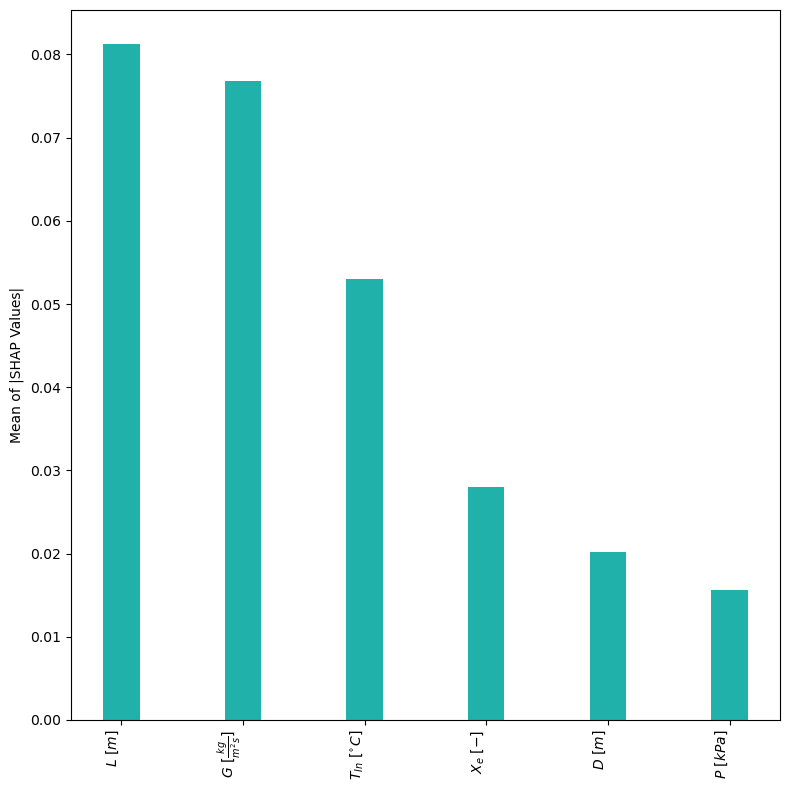

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
df_mean_sorted = shap_mean.iloc[:, 0].sort_values(ascending=False)
print(df_mean_sorted)
ax.bar(df_mean_sorted.index, df_mean_sorted.iloc[:], capsize=4, width=0.3, color="lightseagreen")
ax.set_ylabel("Mean of |SHAP Values|")
plt.xticks(rotation=90, ha="right") ## FIX THIS!
plt.tight_layout()
plt.savefig('shap_kan_chf.png', dpi=300)